In [1]:
import sys,os
import pandas as pd
import numpy as np
import warnings

import tensorflow as tf
from sklearn.utils import shuffle
from joblib import load, dump
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap
import aggmap

warnings.filterwarnings("ignore")

def imshow(x_arr,  ax,  color_list = ['#ff0c00','#25ff00', '#1300ff','#d000ff','#e2ff00', 
              '#00fff6', '#ff8800', '#fccde5','#178b66', '#8a0075'], n_colors=100, x_max = 255, vmin = -1, vmax = 1,):
    
    
    assert x_arr.ndim == 3, 'input must be 3d array!'
    w, h, c = x_arr.shape
    assert len(color_list) >= c, 'length of the color list should equal or larger than channel numbers'
    
    x = x_arr.copy()
    x[x == 0] = 'nan'

    xxx = x_arr.sum(axis=-1)
    xxx[xxx != 0] = 'nan'
        
    
    cmaps = [sns.light_palette(color, n_colors =  n_colors, reverse=False) for color in color_list]

    for i in range(c):
        data = x[:,:,i]/x_max
        sns.heatmap(data, cmap = cmaps[i],  vmin = vmin, vmax = vmax,  
                    yticklabels=False, xticklabels=False, cbar=False, ax=ax, ) # linewidths=0.005, linecolor = '0.9'

    sns.heatmap(xxx, vmin=0, vmax=1, cmap = 'Greys', yticklabels=False, xticklabels=False, cbar=False, ax=ax)
    #-100000
    
    ax.axhline(y=0, color='grey',lw=2, ls =  '--')
    ax.axhline(y=data.shape[0], color='grey',lw=2, ls =  '--')
    
    ax.autoscale()
    ax.axvline(x=data.shape[1], color='grey',lw=2, ls =  '--')  
    ax.axvline(x=0, color='grey',lw=2, ls =  '--')


def imshow_wrap(x,  color_list = ['#ff0c00','#25ff00', '#1300ff','#d000ff','#e2ff00', 
              '#00fff6', '#ff8800', '#fccde5','#178b66', '#8a0075'], n_colors=100, x_max = 255, vmin = -1, vmax = 1):
    fig, ax = plt.subplots(figsize=(4,4))
    imshow(x.astype(float), ax=ax, x_max = x_max, vmin = vmin, vmax=vmax, color_list = color_list,n_colors = n_colors )
    

def tracked_orignal_change(orignal_image, new_mp):
    
    #mp = mp_ORSAggS4
    #orignal_image = trainX_OR1[0]
    df = new_mp._S.df.copy()
    SI = df.groupby('Subtypes').apply(lambda x:x.index.to_list())
    M, N, C = orignal_image.shape
    v = orignal_image.reshape(M*N*C, )
    arr_res = []
    for i, j in SI.items():
        j = [int(k.replace('p-',''))-1 for k in j]
        arr_1d = np.zeros(M*N, )
        arr_1d[j] = v[j]
        arr = arr_1d.reshape(M, N)  
        arr_res.append(arr)
    arr_tracked = np.stack(arr_res, axis=-1)
    return arr_tracked



In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #(x_train, y_train), (x_test, y_test)
mnist_labels_dict = {0: '0', 1: '1',2: '2', 3:'3',4: '4', 5: '5', 6: '6', 7:'7', 8:'8', 9:'9'}
results_save_folder = './imgs'

In [3]:
x_test.shape

(10000, 28, 28)

In [4]:
def gauss_noisy(X, c = 0.38):
    ''' 
    X: 4D array, n,w,h,c
    '''
    X = X/255.
    np.random.seed(123)
    X = np.clip(X + np.random.normal(size = X.shape, scale = c), 0, 1) * 255
    return X

stddevs = np.arange(0, 0.8, 0.12)

testX_noisys = []
testX_noisy_names = []
for stddev in stddevs:
    testX = x_test.reshape(-1, 28,28, 1)
    testX_noisy = gauss_noisy(testX, c = stddev)
    testX_noisys.append(testX_noisy)
    testX_noisy_names.append('stddev: %.2f' % stddev)

In [10]:
testX_noisys[0][-1]

0.0

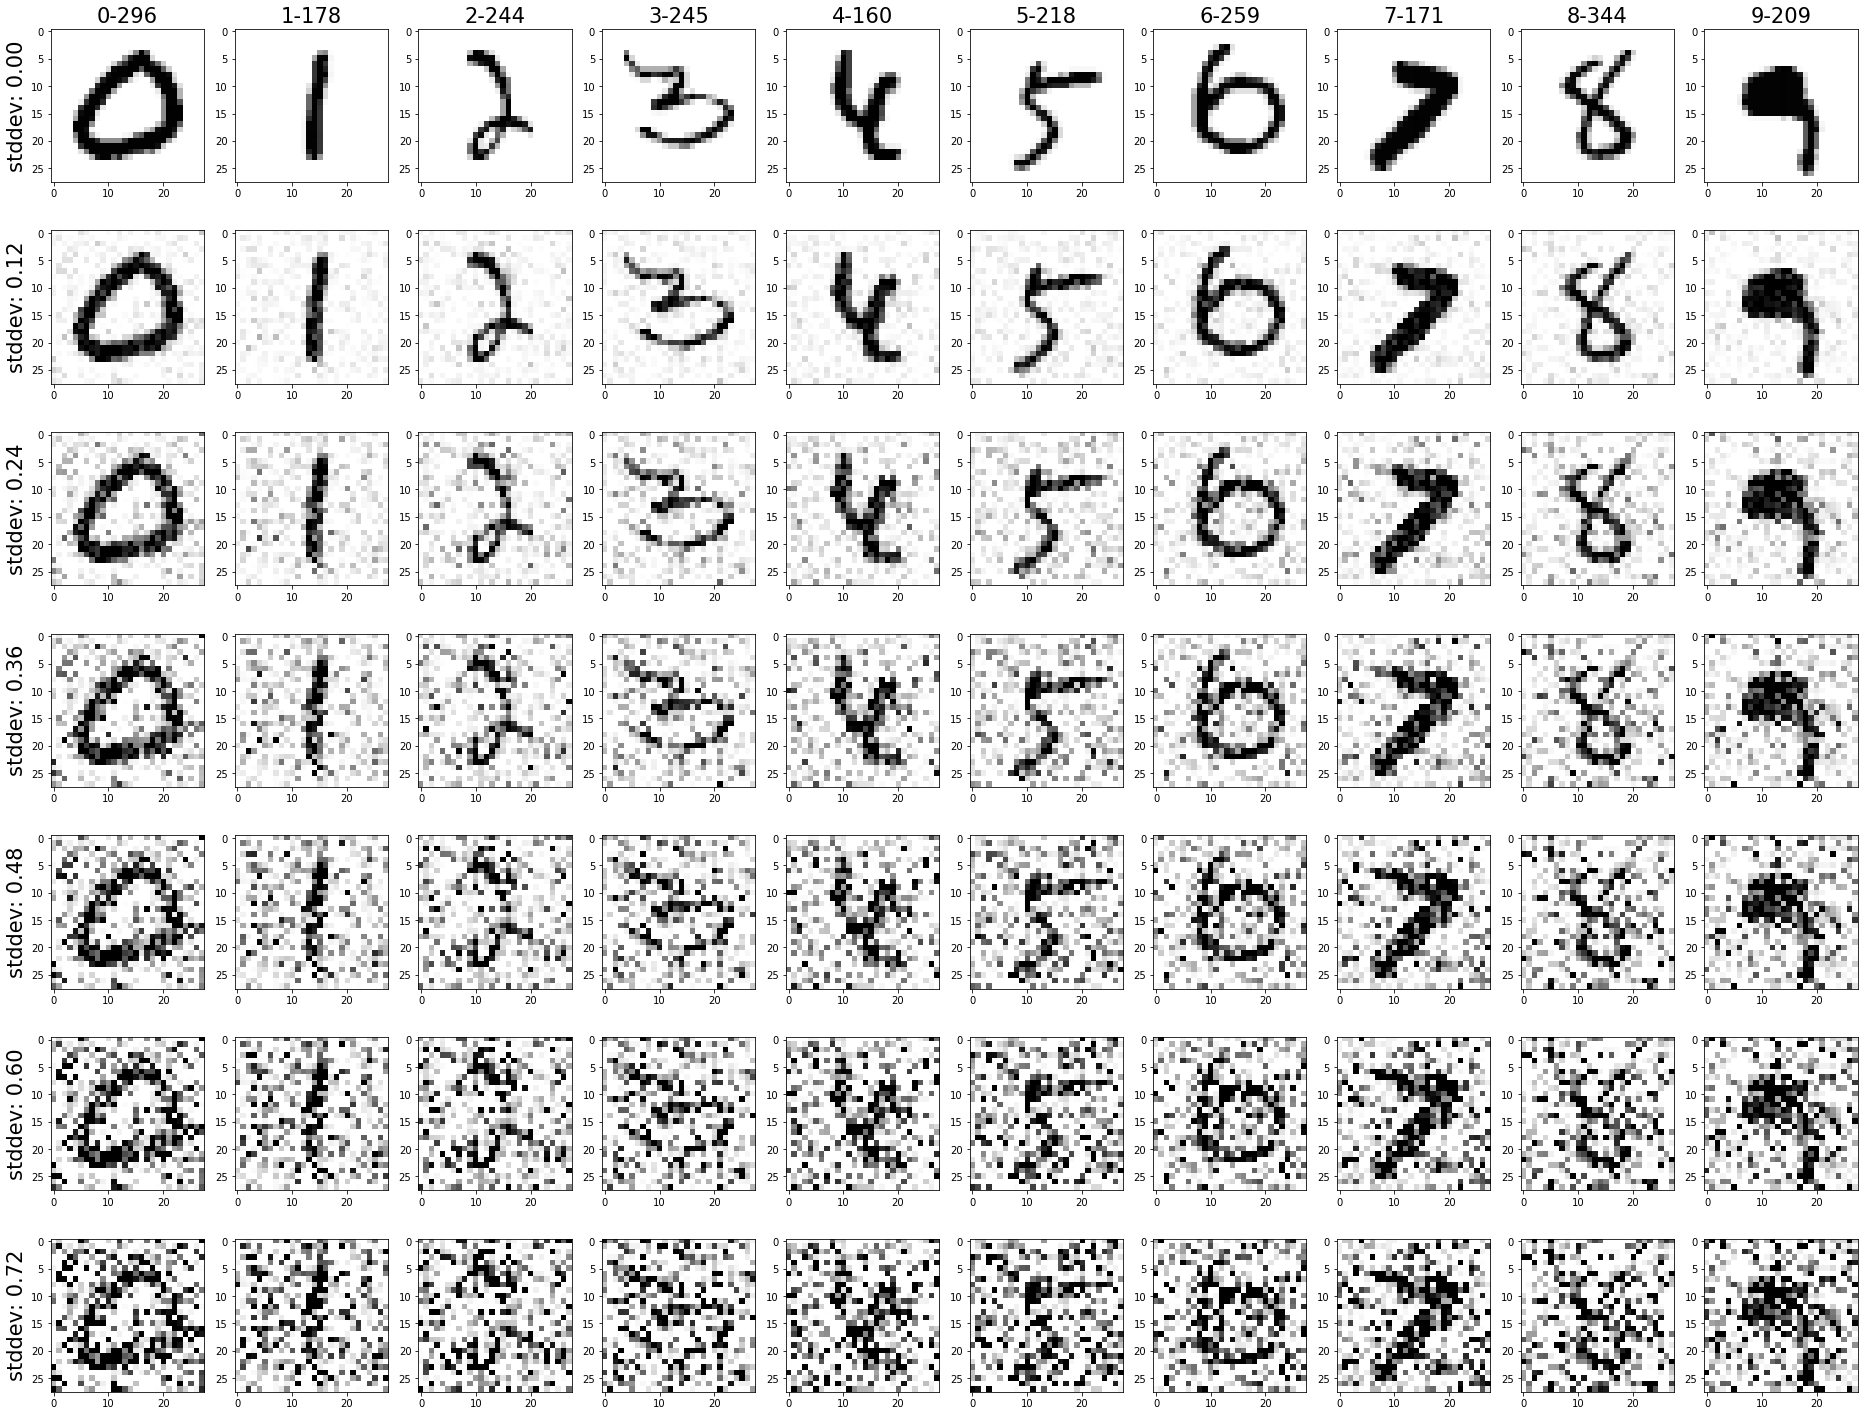

In [15]:
rows = testX_noisy_names
cols = list(mnist_labels_dict.values())

label_idxs = pd.Series(y_test).to_frame(name = 'labels').groupby('labels').apply(lambda x:x.index.to_list())

image_idx = [pd.Series(label_idxs[i][:100]).sample(1, random_state = 32).to_list()[0] for i in range(len(label_idxs))]
cols = [i + '-%s' % j for i,j in zip(cols, image_idx)]

fig, axes = plt.subplots(nrows= len(rows), ncols= len(cols), figsize=(26,20), sharex = False, sharey = False)
fontsize = 21

## plot transformed images
for axc, x_ in zip(axes, testX_noisys):
    for ax, idx in zip(axc, image_idx):
        x = x_[idx].astype(float)
        ax.imshow(x.reshape((28,28)), cmap=plt.cm.Greys)        
        #imshow(x, ax=ax, vmin = 0, vmax = 1) #, color_list = ['black']
        
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': fontsize})
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, fontsize = fontsize)    

fig.tight_layout()
fig.savefig(os.path.join(results_save_folder, 'featuremaps_gauss_noisy.png'), bbox_inches='tight', dpi=300) 